### The end result of this exercise should be a file named acquire.py.

- Using the code from the lesson as a guide and the REST API from https://python.zgulde.net/api/v1/items as we did in the lesson, create a dataframe named items that has all of the data for items.
- Do the same thing, but for stores (https://python.zgulde.net/api/v1/stores)
- Extract the data for sales (https://python.zgulde.net/api/v1/sales). There are a lot of pages of data here, so your code will need to be a little more complex. Your code should continue fetching data from the next page until all of the data is extracted.
- Save the data in your files to local csv files so that it will be faster to access in the future.
- Combine the data from your three separate dataframes into one large dataframe.

In [1]:
# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from sklearn.cluster import KMeans
import requests
import json

# Vis Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE


In [2]:
base_url = 'https://python.zgulde.net'
print(requests.get(base_url).text)

{"api":"/api/v1","help":"/documentation"}



In [3]:
response = requests.get('https://python.zgulde.net/api/v1/items')

data = response.json()
data.keys()

dict_keys(['payload', 'status'])

In [4]:
data['payload'].keys()

dict_keys(['items', 'max_page', 'next_page', 'page', 'previous_page'])

In [5]:
current_page = data['payload']['page']
max_page = data['payload']['max_page']
next_page = data['payload']['next_page']

print(f'current_page: {current_page}')
print(f'max_page: {max_page}')
print(f'next_page: {next_page}')

current_page: 1
max_page: 3
next_page: /api/v1/items?page=2


Here the response has some built-in properties that tell us how to get to subsequent pages.

Once we've drilled down into the data structure, we'll find that the entire response is a sort of wrapper around the items property:

In [6]:
data['payload']['items'][:2]

[{'item_brand': 'Riceland',
  'item_id': 1,
  'item_name': 'Riceland American Jazmine Rice',
  'item_price': 0.84,
  'item_upc12': '35200264013',
  'item_upc14': '35200264013'},
 {'item_brand': 'Caress',
  'item_id': 2,
  'item_name': 'Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct',
  'item_price': 6.44,
  'item_upc12': '11111065925',
  'item_upc14': '11111065925'}]

In [7]:
df = pd.DataFrame(data['payload']['items'])
df.head()

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,Caress,2,Caress Velvet Bliss Ultra Silkening Beauty Bar...,6.44,11111065925,11111065925
2,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
3,Boars Head,4,Boars Head Sliced White American Cheese - 120 Ct,3.14,208528800007,208528800007
4,Back To Nature,5,Back To Nature Gluten Free White Cheddar Rice ...,2.61,759283100036,759283100036


In [8]:
response = requests.get(base_url + data['payload']['next_page'])
data = response.json()

current_page = data['payload']['page']
max_page = data['payload']['max_page']
next_page = data['payload']['next_page']

print(f'current_page: {current_page}')
print(f'max_page: {max_page}')
print(f'next_page: {next_page}')

df = pd.concat([df, pd.DataFrame(data['payload']['items'])]).reset_index()

current_page: 2
max_page: 3
next_page: /api/v1/items?page=3


In [9]:
response = requests.get(base_url + data['payload']['next_page'])
data = response.json()

current_page = data['payload']['page']
max_page = data['payload']['max_page']
next_page = data['payload']['next_page']

print(f'current_page: {current_page}')
print(f'max_page: {max_page}')
print(f'next_page: {next_page}')

df = pd.concat([df, pd.DataFrame(data['payload']['items'])]).reset_index()

current_page: 3
max_page: 3
next_page: None


In [10]:
df.shape

(50, 8)

In [157]:
def acquire_df():
    store_url = 'https://python.zgulde.net/api/v1/stores'
    store_response = requests.get(store_url).json()
    store_response['payload']['stores'][0:3]
    store_df = store_response['payload']['stores']
    # let's get items with a while loop:
    # create a new base url for stores:
    # let's create a new base url and endpoint,
    # change the endpoint programmatically in the loop
    base_url = 'https://python.zgulde.net'
    endpoint = '/api/v1/items'
    # initialize an empty list
    items = []
    
    # make a while loop that does the thing 
    # until its no longer true:
    
    while True:
        url = base_url + endpoint
        response = requests.get(url)
        data = response.json()
        # print(f'Getting page {data['payload']['page']} of {data['payload']['max_page']}: {url}', 
        #       end='')
        items.extend(data['payload']['items'])
        endpoint = data['payload']['next_page']
        if endpoint is None:
            break
    
    items_df = pd.DataFrame(items)
    store_df = pd.DataFrame(store_df)

    # approach #2 with sales:
    # make a for loop, only change the number based on
    # what we get in the max page:
    base_url = 'https://python.zgulde.net/api/v1/sales?page='
    sales = []
    for page_no in range(1,184):
        endpoint = str(page_no)
        response = requests.get(
            base_url+endpoint).json()['payload']['sales']
        print(f'Getting page {endpoint} of 183', end='')
        sales.extend(response)
        
    sales = pd.DataFrame(sales)
    sales = sales.rename(columns={'item': 'item_id', 'store': 'store_id'})
    df = pd.merge(sales, items_df, how='left', on='item_id')
    df = pd.merge(df, store_df, how='left', on='store_id')
    return df

In [158]:
def df_to_csv():
    filename = "df.csv"
    
    # if file is available locally, read it
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    
    # if file not available locally, acquire data from SQL database
    # and write it as csv locally for future use
    else:
        # read the SQL query into a dataframe
        df = acquire_df()
        
        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index=False)

        # Return the dataframe to the calling code
        return df 

In [14]:
df.head()

,level_0,index,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,0,0.0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,1.0,Caress,2,Caress Velvet Bliss Ultra Silkening Beauty Bar...,6.44,11111065925,11111065925
2,2,2.0,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
3,3,3.0,Boars Head,4,Boars Head Sliced White American Cheese - 120 Ct,3.14,208528800007,208528800007
4,4,4.0,Back To Nature,5,Back To Nature Gluten Free White Cheddar Rice ...,2.61,759283100036,759283100036


In [151]:
store_url = 'https://python.zgulde.net/api/v1/stores'
store_response = requests.get(store_url).json()
store_response['payload']['stores'][0:3]
store_df = store_response['payload']['stores']

In [149]:
# let's get items with a while loop:
# create a new base url for stores:
# let's create a new base url and endpoint,
# change the endpoint programmatically in the loop
base_url = 'https://python.zgulde.net'
endpoint = '/api/v1/items'
# initialize an empty list
items = []

# make a while loop that does the thing 
# until its no longer true:

while True:
    url = base_url + endpoint
    response = requests.get(url)
    data = response.json()
    # print(f'Getting page {data['payload']['page']} of {data['payload']['max_page']}: {url}', 
    #       end='')
    items.extend(data['payload']['items'])
    endpoint = data['payload']['next_page']
    if endpoint is None:
        break

In [152]:
items_df = pd.DataFrame(items)
store_df = pd.DataFrame(store_df)


In [144]:
# approach #2 with sales:
# make a for loop, only change the number based on
# what we get in the max page:
base_url = 'https://python.zgulde.net/api/v1/sales?page='
sales = []
for page_no in range(1,184):
    endpoint = str(page_no)
    response = requests.get(
        base_url+endpoint).json()['payload']['sales']
    print(f'Getting page {endpoint} of 183', end='')
    sales.extend(response)

Getting page 1 of 183Getting page 2 of 183Getting page 3 of 183Getting page 4 of 183Getting page 5 of 183Getting page 6 of 183Getting page 7 of 183Getting page 8 of 183Getting page 9 of 183Getting page 10 of 183Getting page 11 of 183Getting page 12 of 183Getting page 13 of 183Getting page 14 of 183Getting page 15 of 183Getting page 16 of 183Getting page 17 of 183Getting page 18 of 183Getting page 19 of 183Getting page 20 of 183Getting page 21 of 183Getting page 22 of 183Getting page 23 of 183Getting page 24 of 183Getting page 25 of 183Getting page 26 of 183Getting page 27 of 183Getting page 28 of 183Getting page 29 of 183Getting page 30 of 183Getting page 31 of 183Getting page 32 of 183Getting page 33 of 183Getting page 34 of 183Getting page 35 of 183Getting page 36 of 183Getting page 37 of 183Getting page 38 of 183Getting page 39 of 183Getting page 40 of 183Getting page 41 of 183Getting page 42 of 183Getting page 43 of 183Getting page 44 of 183Getting page 45 of 183Getting page 46 of 

In [147]:
sales = pd.DataFrame(sales)

In [148]:
sales.head()

,item,sale_amount,sale_date,sale_id,store
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1


In [153]:
sales = sales.rename(columns={'item': 'item_id', 'store': 'store_id'})

In [154]:
df = pd.merge(sales, items_df, how='left', on='item_id')

In [155]:
df = pd.merge(df, store_df, how='left', on='store_id')

In [156]:
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


In [160]:
df = df_to_csv()

Getting page 1 of 183Getting page 2 of 183Getting page 3 of 183Getting page 4 of 183Getting page 5 of 183Getting page 6 of 183Getting page 7 of 183Getting page 8 of 183Getting page 9 of 183Getting page 10 of 183Getting page 11 of 183Getting page 12 of 183Getting page 13 of 183Getting page 14 of 183Getting page 15 of 183Getting page 16 of 183Getting page 17 of 183Getting page 18 of 183Getting page 19 of 183Getting page 20 of 183Getting page 21 of 183Getting page 22 of 183Getting page 23 of 183Getting page 24 of 183Getting page 25 of 183Getting page 26 of 183Getting page 27 of 183Getting page 28 of 183Getting page 29 of 183Getting page 30 of 183Getting page 31 of 183Getting page 32 of 183Getting page 33 of 183Getting page 34 of 183Getting page 35 of 183Getting page 36 of 183Getting page 37 of 183Getting page 38 of 183Getting page 39 of 183Getting page 40 of 183Getting page 41 of 183Getting page 42 of 183Getting page 43 of 183Getting page 44 of 183Getting page 45 of 183Getting page 46 of 

In [161]:
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


- Acquire the Open Power Systems Data for Germany, which has been rapidly expanding its renewable energy production in recent years. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can get the data here: https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions in the acquire.py file and be able to re-run the functions and get the same data.

In [15]:
url = "https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv"
df=pd.read_csv(url)

In [16]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


## Working with Time Series Data

In [17]:
from vega_datasets import data
data.sf_temps()

,temp,date
0,47.8,2010-01-01 00:00:00
1,47.4,2010-01-01 01:00:00
2,46.9,2010-01-01 02:00:00
3,46.5,2010-01-01 03:00:00
4,46.0,2010-01-01 04:00:00
...,...,...
8754,50.4,2010-12-31 19:00:00
8755,49.9,2010-12-31 20:00:00
8756,49.4,2010-12-31 21:00:00
8757,48.8,2010-12-31 22:00:00


In [18]:
df = data.sf_temps()

In [19]:
df.dtypes

temp           float64
date    datetime64[ns]
dtype: object

In [20]:
# df['year'] = df.date.dt.year
# df['month'] = df.date.dt.month
# df['day'] = df.date.dt.day
# df['weekday'] = df.date.dt.day_name()
# df.head()

In [21]:
df = df.set_index('date').sort_index()
df

,temp
date,
2010-01-01 00:00:00,47.8
2010-01-01 01:00:00,47.4
2010-01-01 02:00:00,46.9
2010-01-01 03:00:00,46.5
2010-01-01 04:00:00,46.0
...,...
2010-12-31 19:00:00,50.4
2010-12-31 20:00:00,49.9
2010-12-31 21:00:00,49.4


In [22]:
by_day = df.asfreq('D')
by_day

,temp
date,
2010-01-01,47.8
2010-01-02,47.9
2010-01-03,48.0
2010-01-04,48.1
2010-01-05,48.0
...,...
2010-12-27,47.6
2010-12-28,47.6
2010-12-29,47.6


- Resample by the day and take the average temperature. Visualize the average temperature over time.

<AxesSubplot:xlabel='date'>

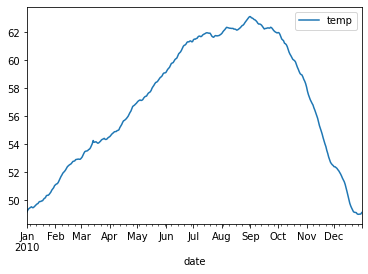

In [23]:
df.resample('1D').mean().plot()

- Write the code necessary to visualize the minimum temperature over time.
- Write the code necessary to visualize the maximum temperature over time.

<AxesSubplot:xlabel='date'>

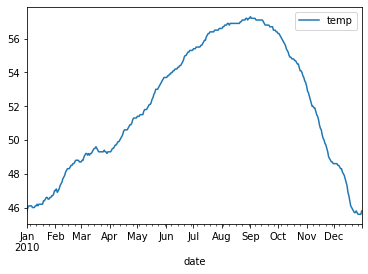

In [24]:
df.resample('1D').min().plot()

<AxesSubplot:xlabel='date'>

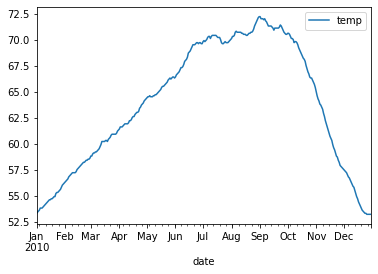

In [25]:
df.resample('1D').max().plot()


- Which month is the coldest, on average?
- Which month has the highest average temperature?

In [26]:
df.resample('1M').mean()

,temp
date,
2010-01-31,49.984140
2010-02-28,52.243899
2010-03-31,53.956528
2010-04-30,55.633056
2010-05-31,57.970968
2010-06-30,60.444722
2010-07-31,61.765457
2010-08-31,62.405376
2010-09-30,62.487083


In [27]:
df.resample('1M').mean().sort_values('temp')

,temp
date,
2010-01-31,49.984140
2010-12-31,50.498253
2010-02-28,52.243899
2010-03-31,53.956528
2010-11-30,55.185139
2010-04-30,55.633056
2010-05-31,57.970968
2010-10-31,60.253091
2010-06-30,60.444722


- January is the coldest month on average
- September is the hottest on average

- Resample by the day and calculate the min and max temp for the day (Hint: .agg(['min', 'max'])). Use this resampled dataframe to calculate the change in temperature for the day. Which month has the highest daily temperature variability?

In [28]:
temp_diff = df.temp.resample('1D').agg(['min', 'max'])

In [29]:
temp_diff

,min,max
date,,
2010-01-01,45.8,53.3
2010-01-02,46.0,53.4
2010-01-03,46.1,53.5
2010-01-04,46.1,53.6
2010-01-05,46.1,53.8
...,...,...
2010-12-27,45.6,53.2
2010-12-28,45.6,53.2
2010-12-29,45.6,53.2


In [30]:
temp_diff['temp_diff'] = temp_diff['max'] - temp_diff['min']

In [31]:
temp_diff.resample('1M').mean().sort_values('temp_diff', ascending=False)

,min,max,temp_diff
date,,,
2010-09-30,56.903333,71.306667,14.403333
2010-07-31,56.045161,70.022581,13.977419
2010-06-30,54.480000,68.430000,13.950000
2010-08-31,56.941935,70.812903,13.870968
2010-10-31,54.932258,68.364516,13.432258
2010-05-31,52.403226,65.312903,12.909677
2010-04-30,50.326667,62.646667,12.320000
2010-03-31,49.238710,60.093548,10.854839
2010-11-30,50.776667,61.013333,10.236667


In [33]:
from vega_datasets import data
data.seattle_weather()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,fog
1457,2015-12-28,1.5,5.0,1.7,1.3,fog
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


### Use the dataset to answer the following questions:

- Which year and month combination has the highest amount of precipitation?



In [55]:
df = data.seattle_weather()

In [56]:
df = df.set_index('date').sort_index()


In [86]:
df.resample('1M').sum().sort_values('precipitation', ascending=False)

,precipitation,temp_max,temp_min,wind,weather_sun
date,,,,,
2015-12-31,284.5,259.8,118.6,134.6,6
2014-03-31,240.0,400.1,168.2,114.0,11
2015-11-30,212.6,290.5,104.4,106.4,9
2012-11-30,210.5,339.8,156.8,96.6,2
2012-03-31,183.0,296.2,88.0,131.7,6
2012-12-31,174.0,224.3,102.1,118.8,1
2012-01-31,173.3,218.7,47.8,120.9,4
2014-10-31,171.5,556.8,337.4,90.4,11
2012-10-31,170.3,490.7,259.8,109.5,11


In [58]:
df.resample('1Y').max().sort_values('precipitation', ascending=False)

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2015-12-31,55.9,35.0,18.3,8.0,sun
2012-12-31,54.1,34.4,18.3,9.5,sun
2014-12-31,46.7,35.6,17.8,8.8,sun
2013-12-31,43.4,33.9,18.3,8.8,sun


- Visualize the amount of monthly precipitation over time.
- Visualize the amount of wind over time. Choose a time interval you think is appropriate.

<AxesSubplot:xlabel='date'>

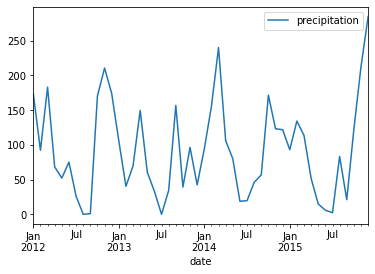

In [87]:
df[['precipitation']].resample('1M').sum().plot()

<AxesSubplot:xlabel='date'>

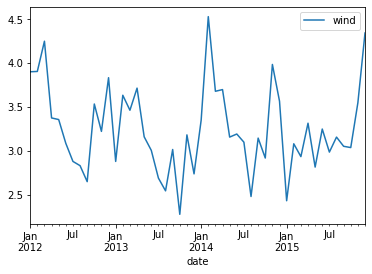

In [68]:
df[['wind']].resample('1M').mean().plot()

- Which year-month combination is the windiest?
- What's the sunniest year? (Hint: which day has the highest number of days where weather == sun?)


In [69]:
df.resample('1M').max().sort_values('wind', ascending=False)

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-12-31,22.6,13.3,8.3,9.5,sun
2014-01-31,21.6,14.4,10.0,8.8,sun
2013-12-31,10.7,13.3,8.3,8.8,sun
2012-01-31,27.7,12.8,7.2,8.2,sun
2013-02-28,9.4,13.3,7.2,8.1,sun
2012-02-29,17.3,16.1,7.8,8.1,sun
2015-11-30,47.2,15.6,9.4,8.0,sun
2012-04-30,10.9,23.3,10.0,8.0,sun
2014-02-28,26.4,14.4,7.8,7.9,sun


In [81]:
df['weather_sun'] = df['weather']=='sun'

In [84]:
df.resample('1Y').sum().sort_values('weather_sun', ascending=False)

,precipitation,temp_max,temp_min,wind,weather_sun
date,,,,,
2014-12-31,1232.8,6203.5,3161.8,1236.5,211
2013-12-31,828.0,5861.5,2976.2,1100.8,205
2015-12-31,1139.2,6361.2,3225.0,1153.3,180
2012-12-31,1226.0,5591.3,2668.0,1244.7,118


- In which month does it rain the most?
- Which month has the most number of days with a non-zero amount of precipitation?

In [85]:
df.resample('1M').sum().sort_values('precipitation', ascending=False)

,precipitation,temp_max,temp_min,wind,weather_sun
date,,,,,
2015-12-31,284.5,259.8,118.6,134.6,6
2014-03-31,240.0,400.1,168.2,114.0,11
2015-11-30,212.6,290.5,104.4,106.4,9
2012-11-30,210.5,339.8,156.8,96.6,2
2012-03-31,183.0,296.2,88.0,131.7,6
2012-12-31,174.0,224.3,102.1,118.8,1
2012-01-31,173.3,218.7,47.8,120.9,4
2014-10-31,171.5,556.8,337.4,90.4,11
2012-10-31,170.3,490.7,259.8,109.5,11


In [88]:
df['rain'] = df['precipitation']>0

In [89]:
df.head()

,precipitation,temp_max,temp_min,wind,weather,weather_sun,rain
date,,,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle,False,False
2012-01-02,10.9,10.6,2.8,4.5,rain,False,True
2012-01-03,0.8,11.7,7.2,2.3,rain,False,True
2012-01-04,20.3,12.2,5.6,4.7,rain,False,True
2012-01-05,1.3,8.9,2.8,6.1,rain,False,True


In [90]:
df.resample('1M').sum().sort_values('rain', ascending=False)

,precipitation,temp_max,temp_min,wind,weather_sun,rain
date,,,,,,
2012-12-31,174.0,224.3,102.1,118.8,1,27
2015-12-31,284.5,259.8,118.6,134.6,6,25
2012-01-31,173.3,218.7,47.8,120.9,4,22
2012-03-31,183.0,296.2,88.0,131.7,6,22
2015-11-30,212.6,290.5,104.4,106.4,9,20
2014-03-31,240.0,400.1,168.2,114.0,11,20
2012-11-30,210.5,339.8,156.8,96.6,2,20
2014-02-28,155.2,229.6,73.8,126.8,11,19
2014-10-31,171.5,556.8,337.4,90.4,11,19


### data.flights_20k()


In [91]:
data.flights_20k()

,date,delay,distance,origin,destination
0,2001-01-13 14:56:00,32,417,SAN,SJC
1,2001-01-31 16:40:00,-5,1093,FLL,ISP
2,2001-02-11 18:39:00,3,293,LBB,DAL
3,2001-01-10 21:00:00,-15,550,MSY,MCO
4,2001-03-30 21:45:00,-2,229,STL,IND
...,...,...,...,...,...
19995,2001-03-22 15:10:00,4,446,SAN,OAK
19996,2001-01-19 13:05:00,-6,1489,SEA,MCI
19997,2001-02-07 11:37:00,-16,1848,MCO,PHX
19998,2001-02-24 16:50:00,42,443,RDU,BNA


- Convert any negative delays to 0.
- Which hour of the day has the highest average delay?
- Does the day of the week make a difference in the delay amount?
- Does the month make a difference in the delay amount?

In [132]:
df = data.flights_20k()

In [133]:
df['delay'][df['delay']<0] = 0


In [135]:
df['weekday'] = df.date.dt.day_name()


In [136]:
df = df.set_index('date').sort_index()

In [137]:
df.resample('60min').mean().sort_values('delay', ascending=False)

,delay,distance
date,,
2001-02-23 03:00:00,360.0,239.0
2001-02-25 00:00:00,260.0,368.0
2001-01-02 03:00:00,245.0,405.0
2001-02-24 22:00:00,210.0,229.0
2001-02-22 00:00:00,195.0,535.0
...,...,...
2001-03-31 01:00:00,NaN,NaN
2001-03-31 02:00:00,NaN,NaN
2001-03-31 03:00:00,NaN,NaN


In [138]:
df.resample('1D').sum().sort_values('delay', ascending=False)


,delay,distance
date,,
2001-01-12,7978,100136
2001-02-09,7941,128013
2001-02-15,6456,116534
2001-02-23,5789,122783
2001-03-16,5675,122593
...,...,...
2001-03-26,882,119087
2001-03-28,831,116278
2001-01-22,688,123173


In [139]:
df.groupby('weekday').delay.sum()

weekday
Friday       53770
Monday       21354
Saturday     19755
Sunday       27221
Thursday     38605
Tuesday      27715
Wednesday    33969
Name: delay, dtype: int64

In [140]:
df['month'] = df.index.month

In [143]:
df.groupby('month').delay.mean()

month
1    11.301592
2    12.306106
3     9.875287
Name: delay, dtype: float64

## Data Preparation

### Using your store items data:

- Convert date column to datetime format.
- Plot the distribution of sale_amount and item_price.
- Set the index to be the datetime variable.
- Add a 'month' and 'day of week' column to your dataframe.


In [191]:
df = df_to_csv()

In [192]:
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


In [193]:
df.sale_date = df.sale_date.str.replace('00:00:00 GMT', '')

In [194]:
df.sale_date = df.sale_date.str.strip()

In [195]:
# Reassign the sale_date column to be a datetime type
df.sale_date = pd.to_datetime(df.sale_date, format='%a, %d %b %Y')

In [196]:
df.dtypes

item_id                   int64
sale_amount             float64
sale_date        datetime64[ns]
sale_id                   int64
store_id                  int64
item_brand               object
item_name                object
item_price              float64
item_upc12                int64
item_upc14                int64
store_address            object
store_city               object
store_state              object
store_zipcode             int64
dtype: object

In [197]:
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,2013-01-01,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,2013-01-02,2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,2013-01-03,3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,2013-01-04,4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,2013-01-05,5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


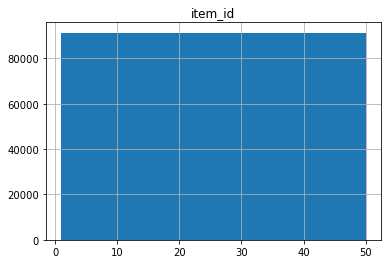

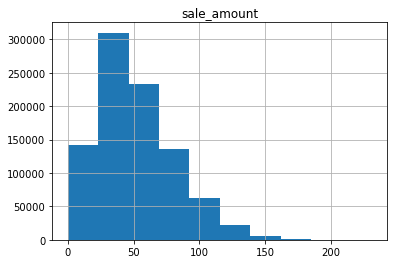

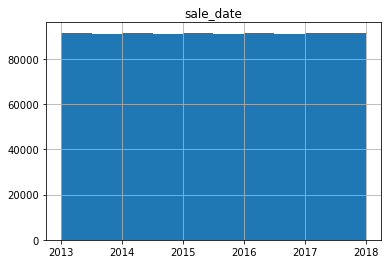

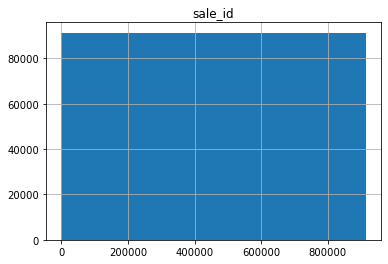

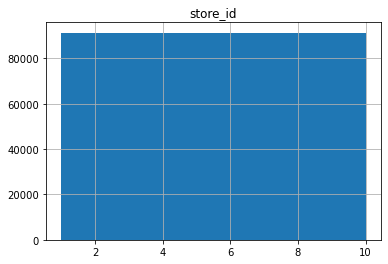

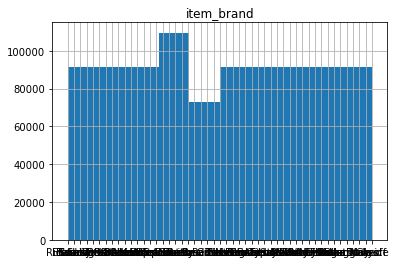

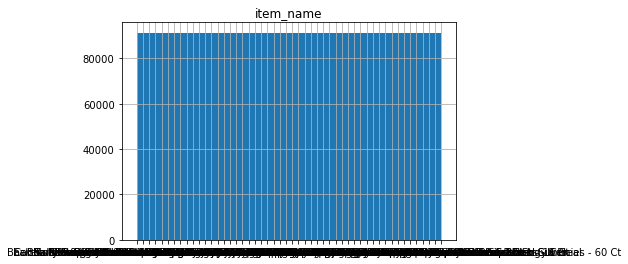

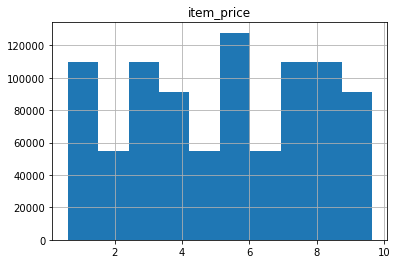

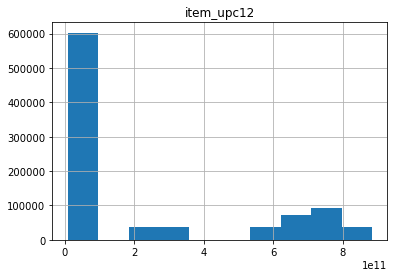

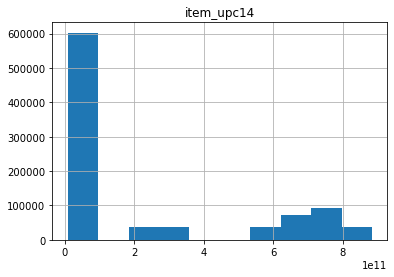

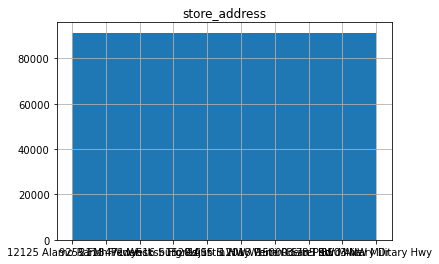

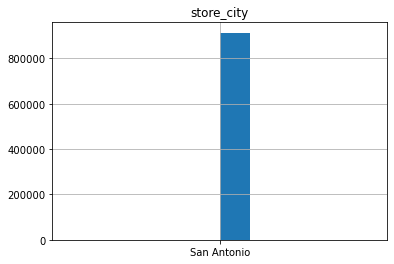

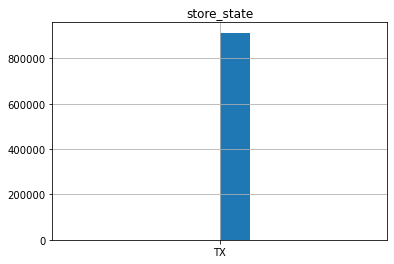

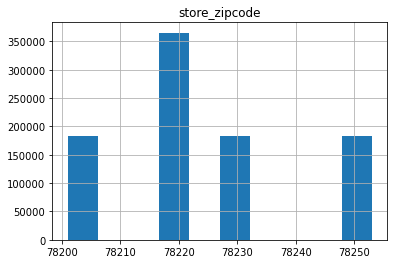

In [198]:
for col in df.columns:
    df[col].hist().plot()
    plt.title(col)
    plt.show()

In [199]:
df['month'] = df.sale_date.dt.month
df['day_of_week'] = df.sale_date.dt.day_name()

In [200]:
df = df.set_index('sale_date')
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Tuesday
2013-01-02,1,11.0,2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Wednesday
2013-01-03,1,14.0,3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Thursday
2013-01-04,1,13.0,4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Friday
2013-01-05,1,10.0,5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Saturday


In [201]:
df = df.sort_index()
df.head(1)

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Tuesday


- Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [202]:
df['sales_total'] = df.sale_amount * df.item_price

In [203]:
df.head(1)

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Tuesday,10.92


In [204]:
def store_prepare(df):
    df.sale_date = df.sale_date.str.replace('00:00:00 GMT', '')
    df.sale_date = df.sale_date.str.strip()
    
    # Reassign the sale_date column to be a datetime type
    df.sale_date = pd.to_datetime(df.sale_date, format='%a, %d %b %Y')
    
    df['month'] = df.sale_date.dt.month
    df['day_of_week'] = df.sale_date.dt.day_name()
    
    df = df.set_index('sale_date')
    df = df.sort_index()

    df['sales_total'] = df.sale_amount * df.item_price
    
    return df

### Using the OPS data acquired in the Acquire exercises opsd_germany_daily.csv, complete the following:

- Convert date column to datetime format.
- Plot the distribution of each of your variables.
- Set the index to be the datetime variable.
- Add a month and a year column to your dataframe.
- Fill any missing values.
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [232]:
url = "https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv"
df=pd.read_csv(url)

In [233]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [234]:
df.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [235]:
df.Date = pd.to_datetime(df.Date)

In [236]:
df.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

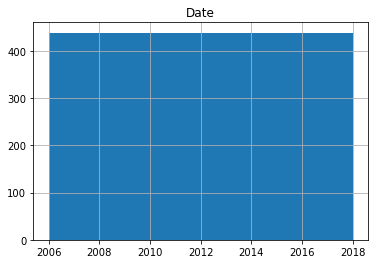

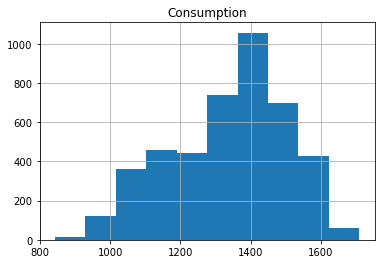

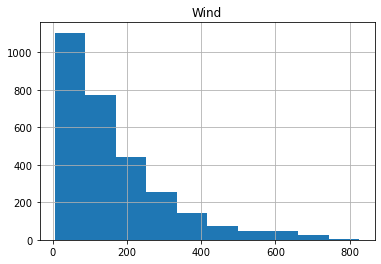

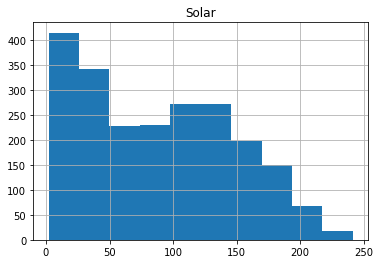

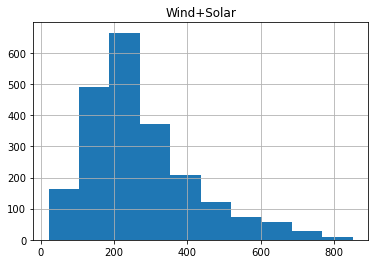

In [237]:
for col in df.columns:
    df[col].hist().plot()
    plt.title(col)
    plt.show()

In [238]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month

In [239]:
df = df.set_index('Date').sort_index()


- Fill any missing values.
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [247]:
df.isnull().sum()

Consumption    0
Wind           0
Solar          0
Wind+Solar     0
year           0
month          0
dtype: int64

In [248]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Consumption,4383.0,1338.675836,165.775710,842.395,1217.859,1367.123,1457.761,1709.568
Wind,4383.0,126.159152,129.497559,5.757,48.709,62.373,162.434,826.278
Solar,4383.0,47.935670,58.489406,1.968,6.587,6.587,86.407,241.580
Wind+Solar,4383.0,253.260973,105.182290,21.478,234.052,234.052,240.746,851.556
year,4383.0,2011.500342,3.452347,2006.000,2008.500,2012.000,2014.500,2017.000
month,4383.0,6.522930,3.449097,1.000,4.000,7.000,10.000,12.000


In [246]:
df.Wind = df.Wind.ffill()
df.Solar = df.Solar.ffill()
df["Wind+Solar"] = df["Wind+Solar"].ffill()
df.Wind = df.Wind.bfill()
df.Solar = df.Solar.bfill()
df["Wind+Solar"] = df["Wind+Solar"].bfill()

In [220]:
df=df.fillna(df.mean())

In [243]:
df.head()

,Consumption,Wind,Solar,Wind+Solar,year,month
Date,,,,,,
2006-01-01,1069.184,NaN,NaN,NaN,2006,1
2006-01-02,1380.521,NaN,NaN,NaN,2006,1
2006-01-03,1442.533,NaN,NaN,NaN,2006,1
2006-01-04,1457.217,NaN,NaN,NaN,2006,1
2006-01-05,1477.131,NaN,NaN,NaN,2006,1


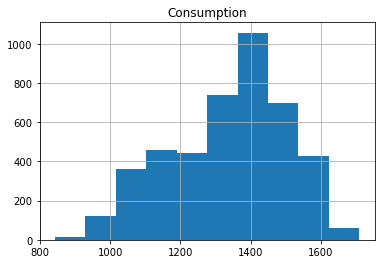

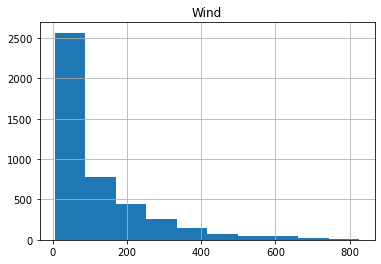

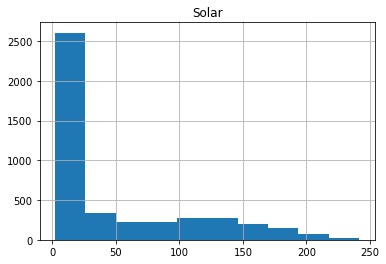

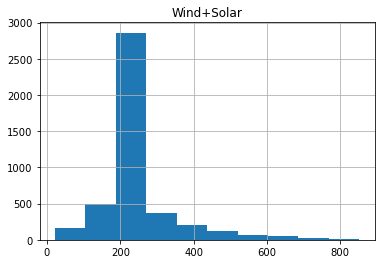

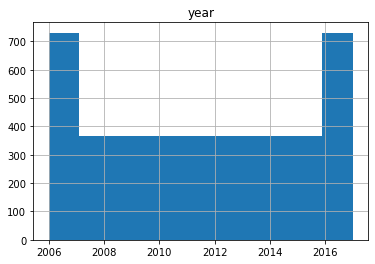

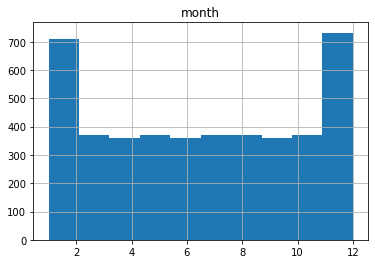

In [249]:
for col in df.columns:
    df[col].hist().plot()
    plt.title(col)
    plt.show()

In [1]:
def prepare_df():
    url = "https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv"
    df=pd.read_csv(url)
    df.Date = pd.to_datetime(df.Date)
    df['year'] = df.Date.dt.year
    df['month'] = df.Date.dt.month
    df = df.set_index('Date').sort_index()
    df.Wind = df.Wind.ffill()
    df.Solar = df.Solar.ffill()
    df["Wind+Solar"] = df["Wind+Solar"].ffill()
    df.Wind = df.Wind.bfill()
    df.Solar = df.Solar.bfill()
    df["Wind+Solar"] = df["Wind+Solar"].bfill()
    df=df.fillna(df.mean())
    return df